In [2]:
import os
import torch
import numpy as np
from IPython.display import Audio
import matplotlib.pyplot as plt

from src.datasets.speech_dataset import SpeechDataset
from src.models.denoise_net import SpeechDenoiseNet
from src.datasets.silence_dataset import SilenceDataset


In [3]:
dataset = SpeechDataset(train=False)
dataset.noisy_data = dataset.clean_data


100%|██████████| 824/824 [00:00<00:00, 11582.20it/s]

Loading validation dataset into memory.
Loading clean data...
Loading noisy data...
Done loading dataset into memory.


In [4]:
net = SpeechDenoiseNet().cpu()
net.eval()
net.training

False

In [5]:
CHECKPOINT_HIGH_LEVEL_FEATURE_LOSS = 'denoise-net-1570664133.ckpt' # Distored, but audible
CHECKPOINT_MORE_LAYERS_FEATURE_LOSS = 'denoise-net-1570667474.ckpt'  # Distored, but audible
CHECKPOINT_LOW_LEVEL_FEATURE_LOSS = 'denoise-net-1570668137.ckpt'  # Silence
ALL_LAYERS_FL = 'denoise-net-1570668767.ckpt'  # Distored, but audible
WEIGHTER_LAYERS = 'denoise-net-1570669439.ckpt'  # Distored, but audible
WEIGHTED_LAYERS_BIGGER_NETWORK = 'denoise-net-1570755894.ckpt'
UNFUCK_OFFSETS = 'denoise-net-1570759641.ckpt'
BACK_TO_MSE = 'denoise-net-1570760344.ckpt'
SILENCE_MSE = 'denoise-net-1570761271.ckpt'
SILENCE_FL = 'denoise-net-1570761416.ckpt'
PASS_THRU_FL = 'denoise-net-1570761823.ckpt'
CP = PASS_THRU_FL
net.load_state_dict(torch.load(os.path.join('checkpoints', CP)))

<All keys matched successfully>

In [6]:
def visualize_results(arr, s):
    print(s)
    plt.figure()
    plt.plot(arr)
    plt.show()
    return Audio(arr, rate=16000)

def get_results(idx):
    in_wav_arr = dataset[idx][0].numpy()
    clean_wav_arr = dataset[idx][1].numpy()
    inputs = torch.tensor(in_wav_arr).float().cpu()
    inputs = inputs.view(1, 1, -1)
    outputs = net(inputs)
    outputs = outputs.squeeze(dim=0)
    wav_arr = outputs.cpu().detach().numpy()
    return wav_arr, in_wav_arr, clean_wav_arr

In [7]:
wav_arr, in_wav_arr, clean_wav_arr = get_results(5)

/home/matt/code/speech-enhancement/speech-enhancement/env/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Predicted clean signal


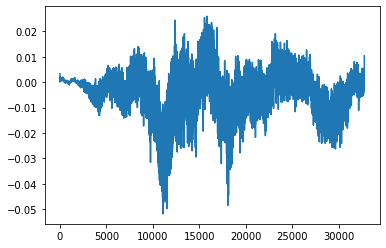

In [8]:
visualize_results(wav_arr, 'Predicted clean signal')

Noisy signal


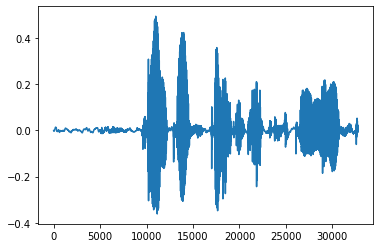

In [9]:
visualize_results(in_wav_arr, 'Noisy signal')

Clean signal


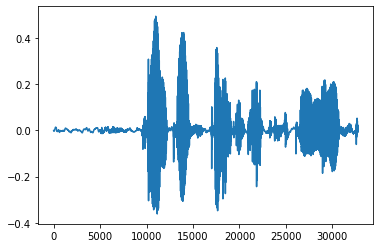

In [10]:
visualize_results(clean_wav_arr, 'Clean signal')